# Выделение признаков факторизацией матрицы

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF

# Создаём временные ряды и визуализируем их

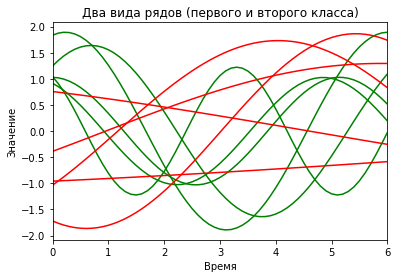

data.shape = (122000, 4)
data.id.nunique() = 2000


,t,y,class,id
0,0.0,3.245872,1,0
1,0.1,3.348260,1,0
2,0.2,3.436487,1,0


In [2]:
N = 1000 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    A = 1 + random.random()        ## амплитуда
    w = 1 + random.random()        ## частота
    ph = np.pi * random.random()   ## фаза
    
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.sin(t*w + ph)  ## значения временного ряда
    df['class'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    data = data.append(df)         ## добавляем семпл в общий дейтафрейм
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['class'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    data = data.append(df)           ## добавляем семпл в общий дейтафрейм
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

print('data.shape =', data.shape)
print('data.id.nunique() =', data.id.nunique())
data.head(3)

# Выделение признаков

## Поворачиваем таблицу

In [4]:
dataPivoted = data.pivot(index='id', columns='t', values='y')
dataPivoted = dataPivoted.reset_index(drop=True)
dataPivoted.loc[ :, 'label'] = 0
dataPivoted.loc[N:, 'label'] = 1
print('dataPivoted.shape =', dataPivoted.shape)
dataPivoted.head(3)

dataPivoted.shape = (2000, 62)


t,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,...,5.2,5.300000000000001,5.4,5.5,5.6000000000000005,5.7,5.800000000000001,5.9,6.0,label
0,3.245872,3.348260,3.436487,3.509626,3.566908,3.607734,3.631673,3.638476,3.628070,3.600564,...,1.853265,2.021114,2.188733,2.354361,2.516261,2.672732,2.822132,2.962893,3.093538,0
1,3.038675,2.911656,2.757190,2.579924,2.385190,2.178845,1.967094,1.756307,1.552825,1.362766,...,0.791555,0.843384,0.929975,1.048725,1.196061,1.367552,1.558040,1.761795,1.972689,0
2,3.834684,3.873698,3.890587,3.885151,3.857455,3.807827,3.736850,3.645365,3.534449,3.405412,...,3.210000,3.360586,3.495104,3.611965,3.709790,3.787425,3.843954,3.878708,3.891279,0


## Факторизация положительно определённой матрицы
Non-negative matrix factorization (NNMF)

In [5]:
# train, test = np.split(dataPivoted, [int(0.6*len(dataPivoted))])
train, test = train_test_split(dataPivoted, test_size=0.4, random_state=43) 
print('train.shape =', train.shape)
print('test.shape  =', test.shape)

## составляем список колонок со временем
timeColumns = train.drop('label', axis=1).columns

## факторизуем (раскладываем исходную матрицу на две)
## описываем требования к разложению (основное - раскладываем на три компоненты)
model = NMF(n_components=3, init='nndsvd', random_state=0, tol=0.001, max_iter=5000, solver='cd')
## находим функции разложения и извлекаем их
model.fit(train[timeColumns])
H = model.components_
## получаем коэффициенты разложения для тренировочного и тестового сетов
W_train = model.transform(train[timeColumns])
W_test  = model.transform(test[timeColumns])

print('H.shape =', H.shape)
print('W_train.shape =', W_train.shape) # выделенные признаки
print('W_test.shape =',  W_test.shape)  # выделенные признаки

train.shape = (1200, 62)
test.shape  = (800, 62)
H.shape = (3, 61)
W_train.shape = (1200, 3)
W_test.shape = (800, 3)


## Визуализируем базисные функции (функции разложения)

Коэффициенты разложения для 4-элемента: [0.58041121 0.72977782 0.        ]


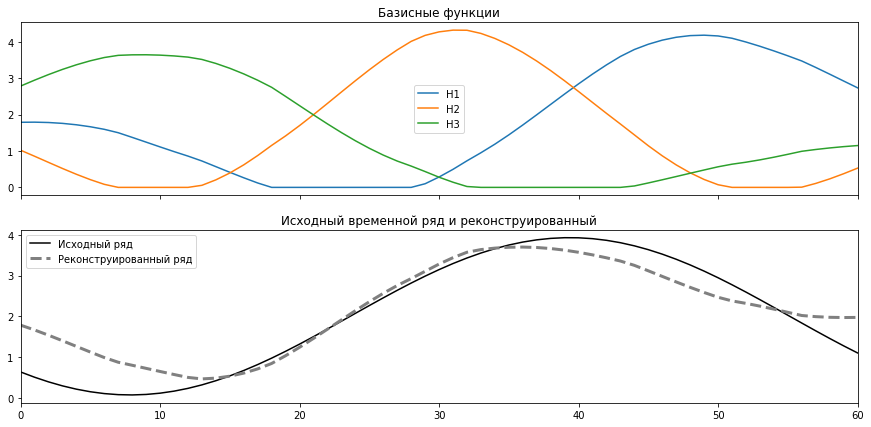

In [8]:
ind = 4

f, ax = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
ax[0].plot(H[0,:])
ax[0].plot(H[1,:])
ax[0].plot(H[2,:])
# ax[0].plot(H[3,:])
# ax[0].plot(H[4,:])
# ax[0].legend(['H1', 'H2', 'H3', 'H4', 'H5'])
ax[0].legend(['H1', 'H2', 'H3'])
ax[0].set_title("Базисные функции")


print(f'Коэффициенты разложения для {ind}-элемента: {W_train[ind]}')
y = train.iloc[ind].values

ax[1].plot(y, 'k')

reconstr = W_train[ind].dot(H)
ax[1].plot(reconstr, color='gray', linestyle='--', lw=3)
ax[1].set_title('Исходный временной ряд и реконструированный')
ax[1].legend(['Исходный ряд', 'Реконструированный ряд'])
ax[1].set_xlim([0, len(y)-2])
plt.show()

# Разбивка на тренировочный и тестовый наборы

In [9]:
trainSet = pd.DataFrame()
testSet = pd.DataFrame()

## записываем фичи в дейтафрейм
for i in range(np.shape(W_train)[1]):
    trainSet['W_' + str(i)] = W_train[:,i]
    
for i in range(np.shape(W_test)[1]):
    testSet['W_' + str(i)] = W_test[:,i]
    
## добавляем классы исходного ряда    
trainSet['label'] = train.label.values
testSet['label']  = test.label.values        

print("trainSet.shape =", trainSet.shape)
print("testSet.shape =",  testSet.shape)
print()
print('Value counts train:\n', trainSet.label.value_counts())
print()
print('Value counts test:\n', testSet.label.value_counts())

trainSet.head(3)

trainSet.shape = (1200, 4)
testSet.shape = (800, 4)

Value counts train:
 1    602
0    598
Name: label, dtype: int64

Value counts test:
 0    402
1    398
Name: label, dtype: int64


,W_0,W_1,W_2,label
0,0.675387,0.000000,0.674082,0
1,0.690431,0.083129,0.621431,0
2,0.296551,0.588453,0.753541,1


# Машинное обучение

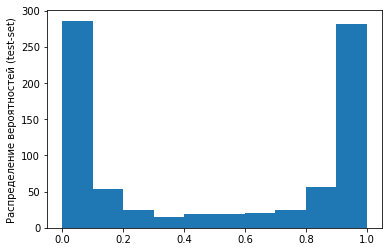

  features  importances
0      W_0     0.392387
1      W_1     0.316823
2      W_2     0.290790

   Pos  Neg
0  372   30
1   28  370

AUC = 0.981  Точность = 0.927



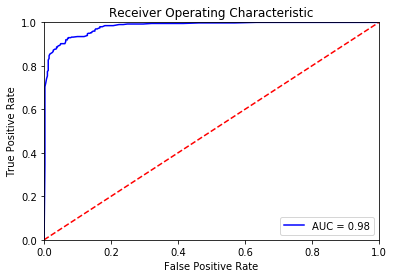

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

featureList = trainSet.drop('label', axis=1).columns

## параметры классификатора
params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced',
         'random_state': 42}

## обучаем классификатор
clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

## делаем предсказание на тестовом наборе
y_pred = clf.predict(testSet[featureList])
y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1] ## вероятности

## визуализируем вероятности для предсказаний
import matplotlib.pyplot as plt
plt.hist(y_pred_proba)
plt.ylabel('Распределение вероятностей (test-set)')
plt.show()

## создадим для удобства дейтафрейм с результатами
res = testSet
res['pred'] = y_pred 
res['pred_proba'] = y_pred_proba

## получаем из классификатора важность фич и отображаем их
ftmprt = pd.DataFrame()
ftmprt['features'] = featureList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=False)
print(ftmprt.head(20))
print()
proba = res.pred_proba

# confusion matrix
CM = confusion_matrix(res['label'], res['pred'])
CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
print(CM_DF)

## считаем матрицу ошибок
FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
roc_auc = auc(FPR, TPR)
acc = res[res['pred'] == res['label']].shape[0] / res.shape[0]
print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Задания

Используйте этот код для решения заданий.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

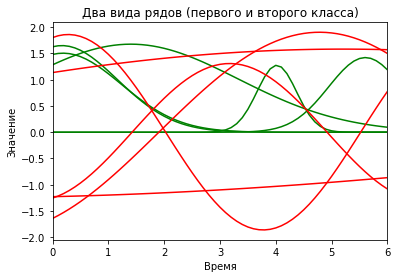

data.shape = (12200, 4)
data.id.nunique() = 200


,t,y,label,id
0,0.0,1.957849,1,0
1,0.1,1.957849,1,0
2,0.2,1.957849,1,0


In [12]:
N = 100 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    t0 = 2*np.pi*random.random()
    a1 = 5*random.random()
    A = 1 + random.random()        
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.exp(-(df.t-t0)**2/2/a1)  ## значения временного ряда
    df['label'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    data = data.append(df)         ## добавляем семпл в общий дейтафрейм
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['label'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    data = data.append(df)           ## добавляем семпл в общий дейтафрейм
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

print('data.shape =', data.shape)
print('data.id.nunique() =', data.id.nunique())
data.head(3)

Задание 8.21.1

Поверните дейтафрейм так, чтобы единицы времени являлись названием колонок. Используйте для этого функцию pivot. Укажите значение колонки "0.8" в первой строке.

In [14]:
dataPivoted = data.pivot(index='id', columns='t', values='y')
dataPivoted = dataPivoted.reset_index(drop=True)
dataPivoted.loc[ :, 'label'] = 0
dataPivoted.loc[N:, 'label'] = 1
print('dataPivoted.shape =', dataPivoted.shape)
display(dataPivoted.head(4))
dataPivoted.loc[0, 0.8]

dataPivoted.shape = (200, 62)


t,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,...,5.2,5.300000000000001,5.4,5.5,5.6000000000000005,5.7,5.800000000000001,5.9,6.0,label
0,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,...,1.962614,1.959628,1.958462,1.958044,1.957907,1.957865,1.957853,1.957850,1.957850,0
1,3.241556,3.289581,3.335656,3.379460,3.420678,3.459009,3.494166,3.525883,3.553915,3.578042,...,2.194464,2.170989,2.149323,2.129392,2.111119,2.094421,2.079213,2.065405,2.052910,0
2,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,1.957849,...,3.134488,3.234827,3.312206,3.361605,3.379718,3.365310,3.319365,3.244966,3.146961,0
3,3.439263,3.457976,3.463092,3.454473,3.432353,3.397332,3.350346,3.292628,3.225652,3.151071,...,1.957865,1.957859,1.957856,1.957853,1.957852,1.957851,1.957850,1.957850,1.957850,0


1.9578494756366658

Задание 8.21.2

Сделайте разбиение на тренировочный и тестовый датасеты при помощи train_test_split c параметрами test_size=0.4, random_state=42. 

После сделайте разложение при помощи NMF с параметрами: n_components=5, init='nndsvd', random_state=42, tol=0.001, max_iter=5000, solver='cd'. 

Натенируйте модель, получите функции разложения Н и коэффициенты разложения W_train, W_test для тренировочного и тестового сетов. Не забудьте убрать колонку label перед тренировкой.

Укажите значение H[0][0] с точностью до второго знака после запятой.

In [15]:
# Сделайте разбиение на тренировочный и тестовый датасеты
train, test = train_test_split(dataPivoted, test_size=0.4, random_state=42) 
print('train.shape =', train.shape)
print('test.shape  =', test.shape)

## составляем список колонок со временем
timeColumns = train.drop('label', axis=1).columns

## факторизуем (раскладываем исходную матрицу на две)
## описываем требования к разложению (основное - раскладываем на три компоненты)
model = NMF(n_components=5, init='nndsvd', random_state=42, tol=0.001, max_iter=5000, solver='cd')
## находим функции разложения и извлекаем их
model.fit(train[timeColumns])
H = model.components_
## получаем коэффициенты разложения для тренировочного и тестового сетов
W_train = model.transform(train[timeColumns])
W_test  = model.transform(test[timeColumns])

print('H.shape =', H.shape)
print('W_train.shape =', W_train.shape) # выделенные признаки
print('W_test.shape =',  W_test.shape)  # выделенные признаки
print('H[0][0] = ', H[0][0])

train.shape = (120, 62)
test.shape  = (80, 62)
H.shape = (5, 61)
W_train.shape = (120, 5)
W_test.shape = (80, 5)
H[0][0] =  0.0


Задание 8.21.3

Реконструируйте нулевой элемент из тренировочного сета, используя базовые функции и коэффициенты разложения. Для этого скалярно перемножьте их. 

Укажите 55-ый элемент реконструированной функции, округлив его до второго знака после запятой.

Коэффициенты разложения для 0-элемента: [0.5269669  0.56869138 0.85182499 0.22941802 1.08754509]


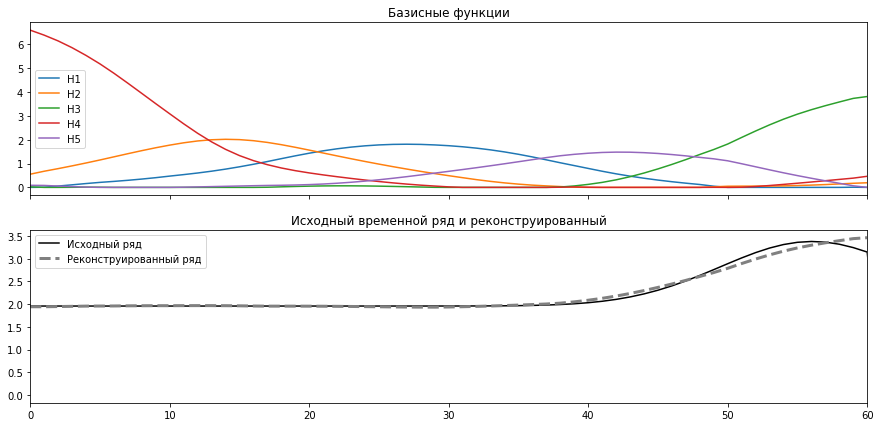

55-й элемент реконструированной функции равен  3.24


In [18]:
ind = 0

f, ax = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
ax[0].plot(H[0,:])
ax[0].plot(H[1,:])
ax[0].plot(H[2,:])
ax[0].plot(H[3,:])
ax[0].plot(H[4,:])
ax[0].legend(['H1', 'H2', 'H3', 'H4', 'H5'])
ax[0].set_title("Базисные функции")


print(f'Коэффициенты разложения для {ind}-элемента: {W_train[ind]}')
y = train.iloc[ind].values

ax[1].plot(y, 'k')

reconstr = W_train[ind].dot(H)
ax[1].plot(reconstr, color='gray', linestyle='--', lw=3)
ax[1].set_title('Исходный временной ряд и реконструированный')
ax[1].legend(['Исходный ряд', 'Реконструированный ряд'])
ax[1].set_xlim([0, len(y)-2])
plt.show()

print('55-й элемент реконструированной функции равен ', round(reconstr[55], 2))

Задание 8.21.4

Укажите площадь под ROC-кривой и точность алгоритма (accuracy). Оба значения округлите до трёх знаков после запятой.

1. Укажите площадь под ROC-кривой
2. Укажите точность алгоритма (accuracy)

In [25]:
trainSet = pd.DataFrame()
testSet = pd.DataFrame()

## записываем фичи в дейтафрейм 
# pd.DataFrame(W_train, columns=['W_0','W_1','W_2','W_3','W_4']).head(3)
for i in range(np.shape(W_train)[1]):
    trainSet['W_' + str(i)] = W_train[:,i]
    
for i in range(np.shape(W_test)[1]):
    testSet['W_' + str(i)] = W_test[:,i]
    
## добавляем классы исходного ряда    
trainSet['label'] = train.label.values
testSet['label']  = test.label.values        

print("trainSet.shape =", trainSet.shape)
print("testSet.shape =",  testSet.shape)
print()
print('Value counts train:\n', trainSet.label.value_counts())
print()
print('Value counts test:\n', testSet.label.value_counts())

trainSet.head(3)

trainSet.shape = (120, 6)
testSet.shape = (80, 6)

Value counts train:
 1    60
0    60
Name: label, dtype: int64

Value counts test:
 1    40
0    40
Name: label, dtype: int64


,W_0,W_1,W_2,W_3,W_4,label
0,0.526967,0.568691,0.851825,0.229418,1.087545,0
1,0.915421,1.114792,0.426635,0.391599,1.128027,0
2,0.273371,0.707296,0.635233,0.203901,1.864772,0


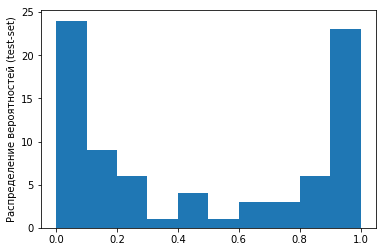

  features  importances
3      W_3     0.404465
2      W_2     0.229784
4      W_4     0.173027
1      W_1     0.137276
0      W_0     0.055448

   Neg  Pos
0   38    2
1    6   34

AUC = 0.972  Точность = 0.900



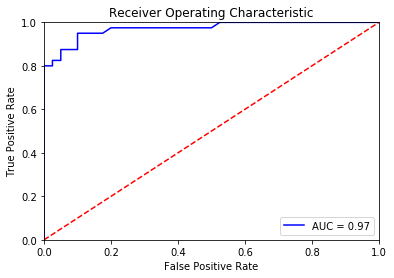

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

featureList = trainSet.drop('label', axis=1).columns

## параметры классификатора
params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced',
         'random_state': 42}

## обучаем классификатор
clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

## делаем предсказание на тестовом наборе
y_pred = clf.predict(testSet[featureList])
y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1] ## вероятности

## визуализируем вероятности для предсказаний
import matplotlib.pyplot as plt
plt.hist(y_pred_proba)
plt.ylabel('Распределение вероятностей (test-set)')
plt.show()

## создадим для удобства дейтафрейм с результатами
res = testSet
res['pred'] = y_pred 
res['pred_proba'] = y_pred_proba

## получаем из классификатора важность фич и отображаем их
ftmprt = pd.DataFrame()
ftmprt['features'] = featureList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=False)
print(ftmprt.head(20))
print()
proba = res.pred_proba

# confusion matrix
CM = confusion_matrix(res['label'], res['pred'])

CM_DF = pd.DataFrame(data=CM, columns = ['Neg', 'Pos'])
print(CM_DF)

## считаем матрицу ошибок
FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
roc_auc = auc(FPR, TPR)
acc = res[res['pred'] == res['label']].shape[0] / res.shape[0]
print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()